In [5]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

### Download data from kaggle

In [6]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

### Choose the block name and print it

In [7]:
idx = 29
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000242,2011-12-03,0.027,0.009,0.018,0.027,0.008,0.021,0.026,0.002,...,0.113,0.114,0.103,0.195,0.126,0.066,0.075,0.068,0.059,0.034
1,MAC000242,2011-12-04,0.029,0.020,0.007,0.028,0.024,0.006,0.025,0.025,...,0.118,0.118,0.110,0.154,0.120,0.197,0.101,0.116,0.036,0.017
2,MAC000242,2011-12-05,0.014,0.027,0.021,0.008,0.025,0.026,0.007,0.021,...,0.320,0.127,0.124,0.102,0.135,0.097,0.127,0.180,0.080,0.074
3,MAC000242,2011-12-06,0.012,0.038,0.004,0.036,0.013,0.025,0.023,0.016,...,0.427,0.150,0.124,0.107,0.120,0.095,0.114,0.116,0.104,0.078
4,MAC000242,2011-12-07,0.022,0.015,0.031,0.017,0.012,0.029,0.017,0.012,...,0.111,0.116,0.141,0.104,0.109,0.154,0.146,0.107,0.125,0.019


### This function is used to fill the gaps between days (missing days)

In [8]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [9]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [10]:
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000242,2011-12-03,0.027,0.009,0.018,0.027,0.008,0.021,0.026,0.002,...,0.113,0.114,0.103,0.195,0.126,0.066,0.075,0.068,0.059,0.034
1,MAC000242,2011-12-04,0.029,0.020,0.007,0.028,0.024,0.006,0.025,0.025,...,0.118,0.118,0.110,0.154,0.120,0.197,0.101,0.116,0.036,0.017
2,MAC000242,2011-12-05,0.014,0.027,0.021,0.008,0.025,0.026,0.007,0.021,...,0.320,0.127,0.124,0.102,0.135,0.097,0.127,0.180,0.080,0.074
3,MAC000242,2011-12-06,0.012,0.038,0.004,0.036,0.013,0.025,0.023,0.016,...,0.427,0.150,0.124,0.107,0.120,0.095,0.114,0.116,0.104,0.078
4,MAC000242,2011-12-07,0.022,0.015,0.031,0.017,0.012,0.029,0.017,0.012,...,0.111,0.116,0.141,0.104,0.109,0.154,0.146,0.107,0.125,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33472,MAC005032,2014-02-23,0.239,0.127,0.167,0.164,0.142,0.132,0.067,0.116,...,0.358,0.152,0.204,0.250,0.251,0.255,0.345,0.246,0.196,0.253
33473,MAC005032,2014-02-24,0.240,0.239,0.263,0.133,0.097,0.087,0.085,0.151,...,0.200,0.165,0.625,0.241,0.117,0.150,0.204,0.234,0.266,0.240
33474,MAC005032,2014-02-25,0.219,0.248,0.226,0.226,0.155,0.075,0.081,0.096,...,0.494,0.186,0.194,0.232,0.232,0.219,0.222,0.212,0.172,0.374
33475,MAC005032,2014-02-26,0.206,0.166,0.184,0.118,0.135,0.146,0.100,0.150,...,0.179,0.133,0.179,0.118,0.108,0.177,0.131,0.217,0.211,0.356


In [11]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-11-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


,day,LCLid,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2011-12-03,MAC000242,0.027,0.009,0.018,0.027,0.008,0.021,0.026,0.002,...,0.113,0.114,0.103,0.195,0.126,0.066,0.075,0.068,0.059,0.034
1,2011-12-04,MAC000242,0.029,0.020,0.007,0.028,0.024,0.006,0.025,0.025,...,0.118,0.118,0.110,0.154,0.120,0.197,0.101,0.116,0.036,0.017
2,2011-12-05,MAC000242,0.014,0.027,0.021,0.008,0.025,0.026,0.007,0.021,...,0.320,0.127,0.124,0.102,0.135,0.097,0.127,0.180,0.080,0.074
3,2011-12-06,MAC000242,0.012,0.038,0.004,0.036,0.013,0.025,0.023,0.016,...,0.427,0.150,0.124,0.107,0.120,0.095,0.114,0.116,0.104,0.078
4,2011-12-07,MAC000242,0.022,0.015,0.031,0.017,0.012,0.029,0.017,0.012,...,0.111,0.116,0.141,0.104,0.109,0.154,0.146,0.107,0.125,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33684,2014-02-23,MAC005032,0.239,0.127,0.167,0.164,0.142,0.132,0.067,0.116,...,0.358,0.152,0.204,0.250,0.251,0.255,0.345,0.246,0.196,0.253
33685,2014-02-24,MAC005032,0.240,0.239,0.263,0.133,0.097,0.087,0.085,0.151,...,0.200,0.165,0.625,0.241,0.117,0.150,0.204,0.234,0.266,0.240
33686,2014-02-25,MAC005032,0.219,0.248,0.226,0.226,0.155,0.075,0.081,0.096,...,0.494,0.186,0.194,0.232,0.232,0.219,0.222,0.212,0.172,0.374
33687,2014-02-26,MAC005032,0.206,0.166,0.184,0.118,0.135,0.146,0.100,0.150,...,0.179,0.133,0.179,0.118,0.108,0.177,0.131,0.217,0.211,0.356


In [12]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-12-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


,LCLid,timestamp,energy_consumption,frequency,serie_length
0,MAC000242,2011-12-03 00:00:00,0.027,30min,38832
1,MAC000242,2011-12-03 00:30:00,0.009,30min,38832
2,MAC000242,2011-12-03 01:00:00,0.018,30min,38832
3,MAC000242,2011-12-03 01:30:00,0.027,30min,38832
4,MAC000242,2011-12-03 02:00:00,0.008,30min,38832
...,...,...,...,...,...
1606891,MAC005032,2014-02-23 21:30:00,0.153,30min,36192
1606892,MAC005032,2014-02-23 22:00:00,0.248,30min,36192
1606893,MAC005032,2014-02-23 22:30:00,0.179,30min,36192
1606894,MAC005032,2014-02-23 23:00:00,0.154,30min,36192


In [13]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col


In [14]:
ts_df = expand_form[expand_form.LCLid=="MAC005032"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [15]:
ts_df

,LCLid,energy_consumption,frequency,serie_length
timestamp,,,,
2012-02-01 00:00:00,MAC005032,0.164,30min,36192
2012-02-01 00:30:00,MAC005032,0.156,30min,36192
2012-02-01 01:00:00,MAC005032,0.110,30min,36192
2012-02-01 01:30:00,MAC005032,0.182,30min,36192
2012-02-01 02:00:00,MAC005032,0.140,30min,36192
...,...,...,...,...
2014-02-23 21:30:00,MAC005032,0.153,30min,36192
2014-02-23 22:00:00,MAC005032,0.248,30min,36192
2014-02-23 22:30:00,MAC005032,0.179,30min,36192


In [16]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [17]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [18]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [19]:
ts_df

,LCLid,energy_consumption,frequency,serie_length,weekday_name,weekday,week,day,hour,date,month,month_name,year
timestamp,,,,,,,,,,,,,
2012-02-01 00:00:00,MAC005032,0.164,30min,36192,Wednesday,2,5,1,0,2012-02-01,2,February,2012
2012-02-01 00:30:00,MAC005032,0.156,30min,36192,Wednesday,2,5,1,0,2012-02-01,2,February,2012
2012-02-01 01:00:00,MAC005032,0.110,30min,36192,Wednesday,2,5,1,1,2012-02-01,2,February,2012
2012-02-01 01:30:00,MAC005032,0.182,30min,36192,Wednesday,2,5,1,1,2012-02-01,2,February,2012
2012-02-01 02:00:00,MAC005032,0.140,30min,36192,Wednesday,2,5,1,2,2012-02-01,2,February,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23 21:30:00,MAC005032,0.153,30min,36192,Sunday,6,8,23,21,2014-02-23,2,February,2014
2014-02-23 22:00:00,MAC005032,0.248,30min,36192,Sunday,6,8,23,22,2014-02-23,2,February,2014
2014-02-23 22:30:00,MAC005032,0.179,30min,36192,Sunday,6,8,23,22,2014-02-23,2,February,2014


### Show stationarity for precision hourly, daily, weekly and monthly

### 1. First analyze the stationarity for precision hourly

In [113]:
hourly_df = ts_df.groupby(["year","month","week","day","hour"])[['energy_consumption']].mean()
hourly_df

energy_consumption
year month week day hour                    
2012 2     5    1   0                 0.1600
                    1                 0.1460
                    2                 0.1590
                    3                 0.1140
                    4                 0.1565
...                                      ...
2014 2     8    23  19                0.1900
                    20                0.1705
                    21                0.1735
                    22                0.2135
                    23                0.2020

[18096 rows x 1 columns]

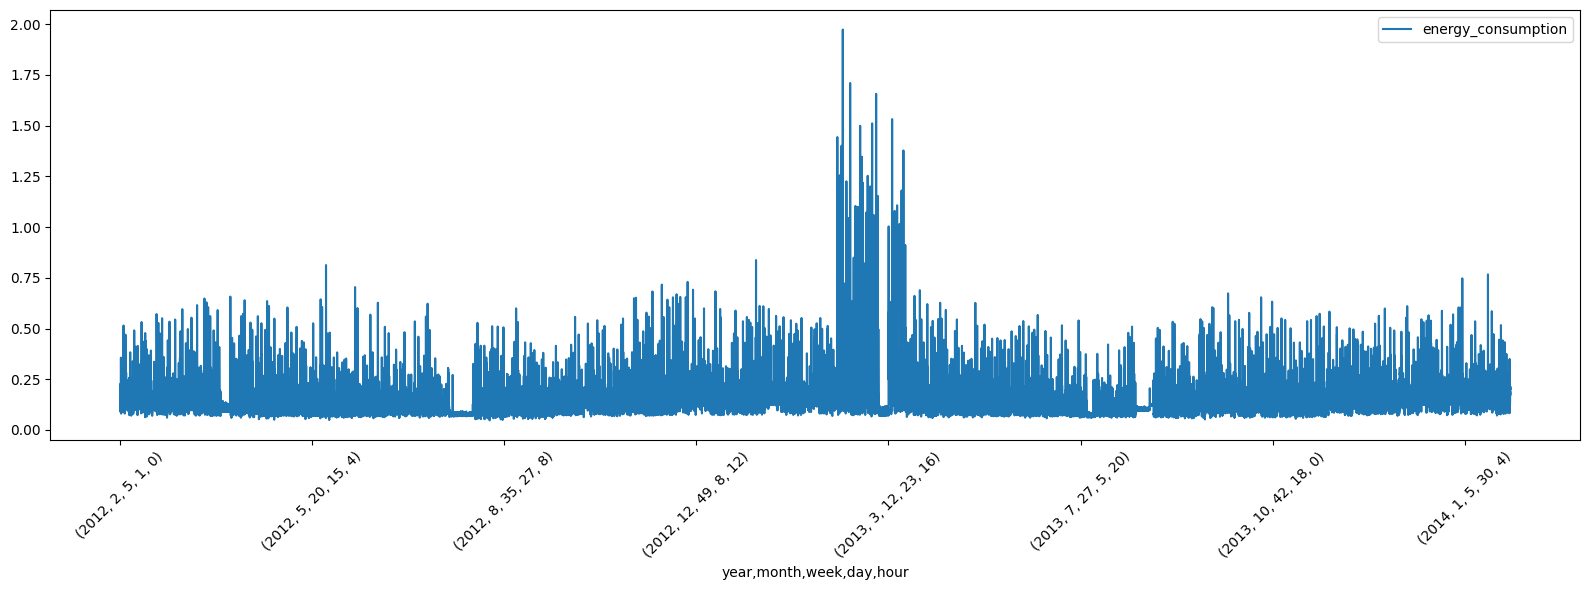

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
hourly_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### In this graph (serie plot) there is no tend or seasonality so it seems startionary be hour

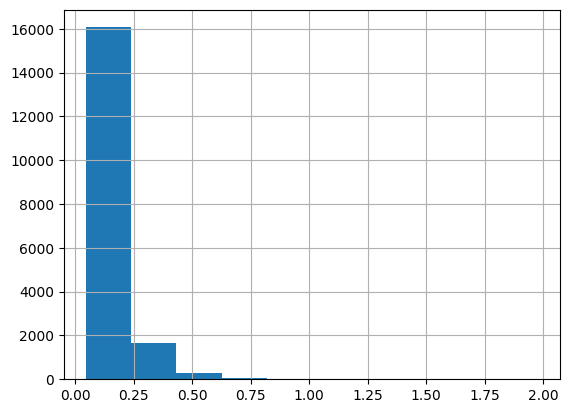

In [86]:
pd.Series(hourly_df["energy_consumption"]).hist();

### In the histogram iit seems normal distribution so there is no trend

In [31]:
hourly_df_chunks = ts_df.groupby(["year","month","week","day","hour"])[['energy_consumption']].agg(['mean', 'var']).reset_index()
# Flatten MultiIndex columns
hourly_df_chunks.columns = ['_'.join(col).strip('_') for col in hourly_df_chunks.columns.values]

# Display
print("hour | Mean       | Variance")
print("-" * 32)
for _, row in hourly_df_chunks.iterrows():
    print(f"{int(row['hour']):4} | {row['energy_consumption_mean']:.6f} | {row['energy_consumption_var']:.6f}")


Streaming output truncated to the last 5000 lines.
  16 | 0.108500 | 0.002964
  17 | 0.107500 | 0.000180
  18 | 0.111500 | 0.000364
  19 | 0.112500 | 0.000364
  20 | 0.098000 | 0.000002
  21 | 0.110000 | 0.000450
  22 | 0.117500 | 0.000421
  23 | 0.129000 | 0.000288
   0 | 0.104000 | 0.001458
   1 | 0.090000 | 0.000032
   2 | 0.148000 | 0.004418
   3 | 0.068500 | 0.000084
   4 | 0.071500 | 0.001013
   5 | 0.086500 | 0.000024
   6 | 0.075000 | 0.000882
   7 | 0.069000 | 0.000018
   8 | 0.217000 | 0.000018
   9 | 0.122000 | 0.001352
  10 | 0.096000 | 0.000288
  11 | 0.166000 | 0.003362
  12 | 0.210500 | 0.017112
  13 | 0.142500 | 0.000313
  14 | 0.100500 | 0.000060
  15 | 0.084000 | 0.000288
  16 | 0.073500 | 0.000613
  17 | 0.479000 | 0.005202
  18 | 0.229500 | 0.000084
  19 | 0.098500 | 0.001404
  20 | 0.205000 | 0.014792
  21 | 0.257500 | 0.000544
  22 | 0.247000 | 0.000800
  23 | 0.230000 | 0.000242
   0 | 0.169500 | 0.015313
   1 | 0.078500 | 0.000545
   2 | 0.069000 | 0.000018
   3

### There is no high difference between means and also between variances so the data is stationary

In [32]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_df)
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here < .05 so the data is stationary")

The adf is :-10.336275666770067,
 The pvalue is :2.75862573925783e-18,
 The critical_values is :{'1%': np.float64(-3.430712339624161), '5%': np.float64(-2.8617001404262346), '10%': np.float64(-2.566855238538685)}
The pvalue is here < .05 so the data is stationary


In [33]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(hourly_df)

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here < .05 so the data is non stationary")

The kpss is :1.9294345806711832,
 The pvalue is :0.01,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here < .05 so the data is non stationary


<ipython-input-33-c4585e41df85>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(hourly_df)


### There is conflict between two teasts  
- KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

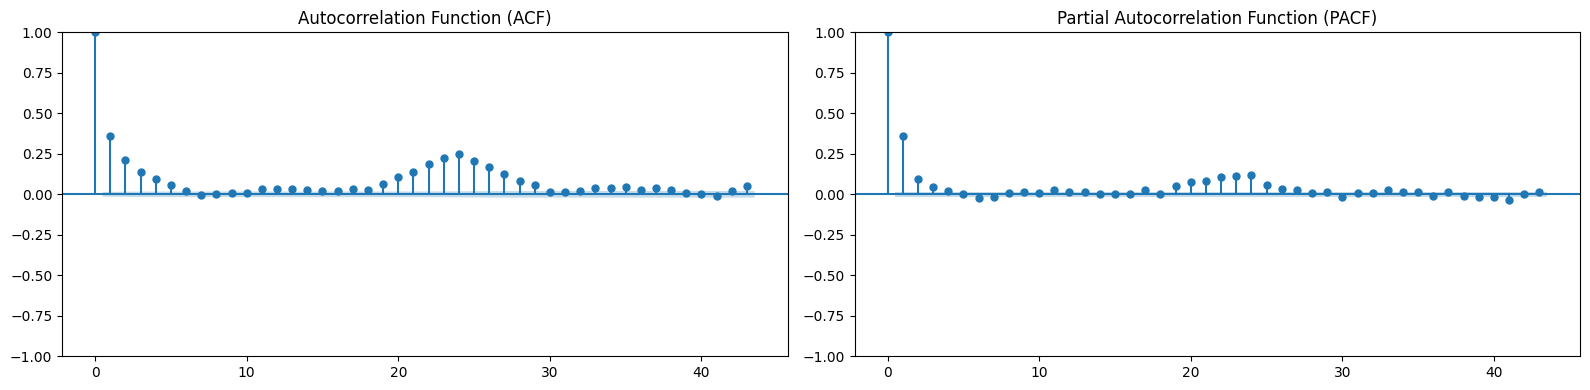

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(hourly_df, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(hourly_df, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [46]:
hourly_df_diff2= hourly_df.diff(periods=2)
hourly_df_diff2

energy_consumption
year month week day hour                    
2012 2     5    1   0                    NaN
                    1                    NaN
                    2                -0.0010
                    3                -0.0320
                    4                -0.0025
...                                      ...
2014 2     8    23  19                0.0625
                    20                0.0030
                    21               -0.0165
                    22                0.0430
                    23                0.0285

[18096 rows x 1 columns]

In [47]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_df_diff2[2:] )
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here < .05 so the data is stationary")

The adf is :-36.52778084160069,
 The pvalue is :0.0,
 The critical_values is :{'1%': np.float64(-3.430712379782758), '5%': np.float64(-2.8617001581737345), '10%': np.float64(-2.566855247985401)}
The pvalue is here < .05 so the data is stationary


In [48]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(hourly_df_diff2[2:] )

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is stationary")

The kpss is :0.026165596132448635,
 The pvalue is :0.1,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here > .05 so the data is stationary


<ipython-input-48-d5d9f7d618f0>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(hourly_df_diff2[2:] )


### After differencing by 2 lags the two tests confirm that the data is stationary (without the autocorrelation)

### Data plot after make it strong stationary

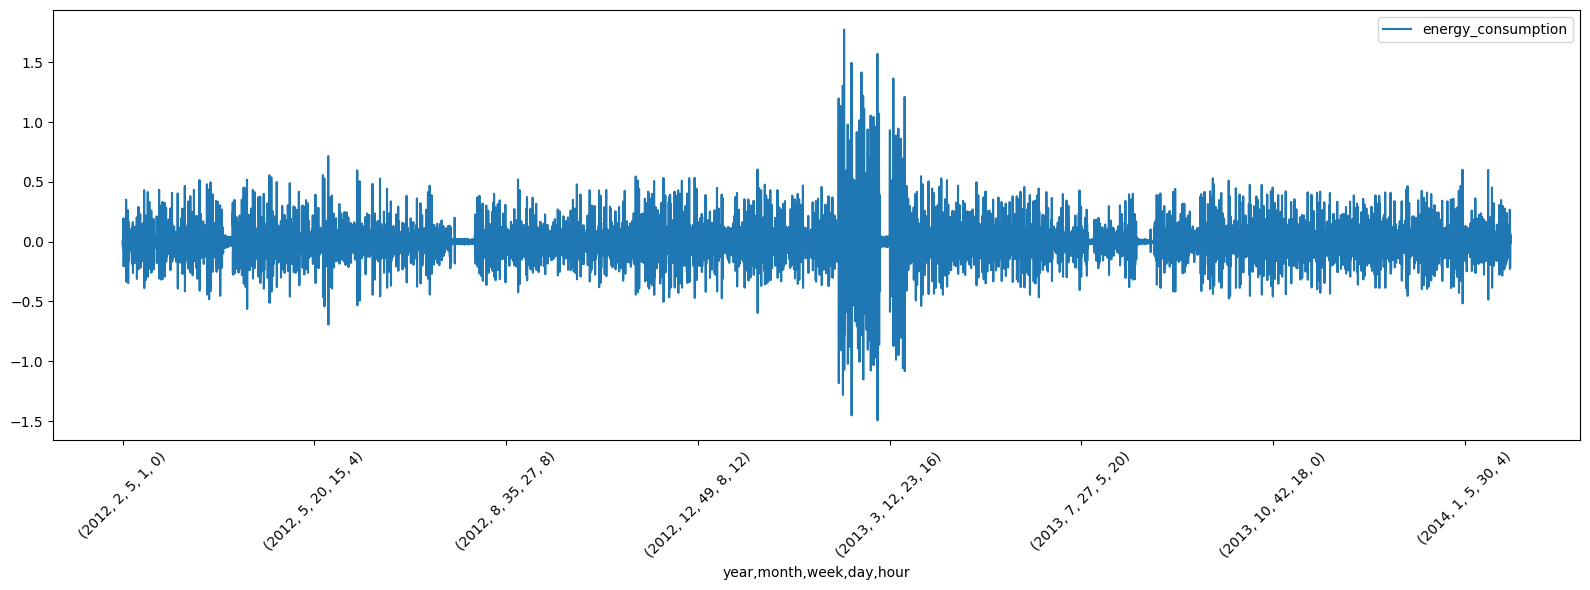

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
hourly_df_diff2.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

In [50]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

def mse(observations, estimates):

    # check arg types
    assert isinstance(observations, np.ndarray), "'observations' must be a numpy array"
    assert isinstance(estimates, np.ndarray), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"

    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)

    return mse

In [174]:
train = hourly_df.to_numpy()[:-1000]
test = hourly_df.to_numpy()[-1000:]
train_time = np.arange(0, len(train))
test_time = np.arange(len(train), len(train) + len(test))

1. Single Exponential Smoothing (SES)

In [79]:
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286 0.18369286
 0.18369286 0.18369286 0.18369286 0.18369286 0.1

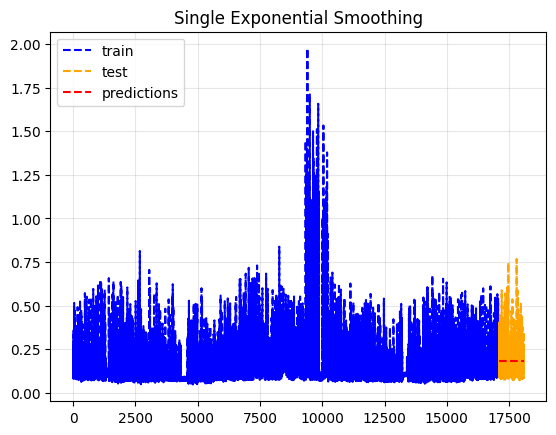

In [80]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

2. Double Exponential Smoothing (DES) - Holt's Linear Trend Method

In [70]:
double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [0.14380128 0.14368815 0.14357502 0.14346189 0.14334875 0.14323562
 0.14312249 0.14300936 0.14289622 0.14278309 0.14266996 0.14255682
 0.14244369 0.14233056 0.14221743 0.14210429 0.14199116 0.14187803
 0.1417649  0.14165176 0.14153863 0.1414255  0.14131237 0.14119923
 0.1410861  0.14097297 0.14085983 0.1407467  0.14063357 0.14052044
 0.1404073  0.14029417 0.14018104 0.14006791 0.13995477 0.13984164
 0.13972851 0.13961538 0.13950224 0.13938911 0.13927598 0.13916285
 0.13904971 0.13893658 0.13882345 0.13871031 0.13859718 0.13848405
 0.13837092 0.13825778 0.13814465 0.13803152 0.13791839 0.13780525
 0.13769212 0.13757899 0.13746586 0.13735272 0.13723959 0.13712646
 0.13701332 0.13690019 0.13678706 0.13667393 0.13656079 0.13644766
 0.13633453 0.1362214  0.13610826 0.13599513 0.135882   0.13576887
 0.13565573 0.1355426  0.13542947 0.13531633 0.1352032  0.13509007
 0.13497694 0.1348638  0.13475067 0.13463754 0.13452441 0.13441127
 0.13429814 0.13418501 0.13407188 0.13395874 0.1

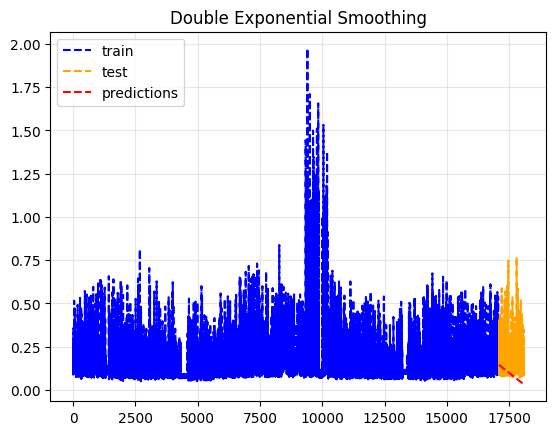

In [81]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

3. Triple Exponential Smoothing (TES) - Holt-Winters' Seasonal Method

In [72]:
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [0.18028638 0.18676115 0.18579079 0.18396695 0.18534735 0.18273762
 0.18755385 0.18576171 0.17903981 0.18499863 0.18399943 0.18426596
 0.17897276 0.18029906 0.18677383 0.18580347 0.18397963 0.18536004
 0.18275031 0.18756653 0.1857744  0.1790525  0.18501132 0.18401212
 0.18427865 0.17898545 0.18031175 0.18678652 0.18581616 0.18399232
 0.18537273 0.18276299 0.18757922 0.18578709 0.17906519 0.18502401
 0.1840248  0.18429134 0.17899813 0.18032444 0.18679921 0.18582885
 0.18400501 0.18538541 0.18277568 0.18759191 0.18579977 0.17907787
 0.1850367  0.18403749 0.18430402 0.17901082 0.18033712 0.18681189
 0.18584154 0.1840177  0.1853981  0.18278837 0.18760459 0.18581246
 0.17909056 0.18504938 0.18405018 0.18431671 0.17902351 0.18034981
 0.18682458 0.18585422 0.18403038 0.18541079 0.18280106 0.18761728
 0.18582515 0.17910325 0.18506207 0.18406287 0.1843294  0.1790362
 0.1803625  0.18683727 0.18586691 0.18404307 0.18542348 0.18281374
 0.18762997 0.18583783 0.17911593 0.18507476 0.18

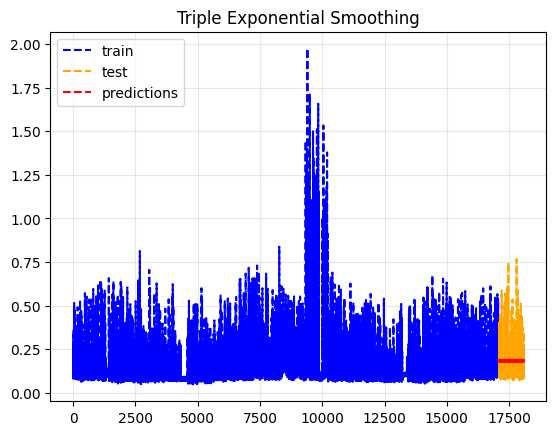

In [82]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

### IN The three methods the model cant fit the data because there is no trend or seasonality

### 1. Now analyze the stationarity for precision daily

In [83]:
daily_df = ts_df.groupby(["year","month","week","day"])[['energy_consumption']].mean()
daily_df

energy_consumption
year month week day                    
2012 2     5    1              0.161500
                2              0.174458
                3              0.203833
                4              0.149083
                5              0.159729
...                                 ...
2014 2     8    19             0.181354
                20             0.172125
                21             0.188833
                22             0.153979
                23             0.171813

[754 rows x 1 columns]

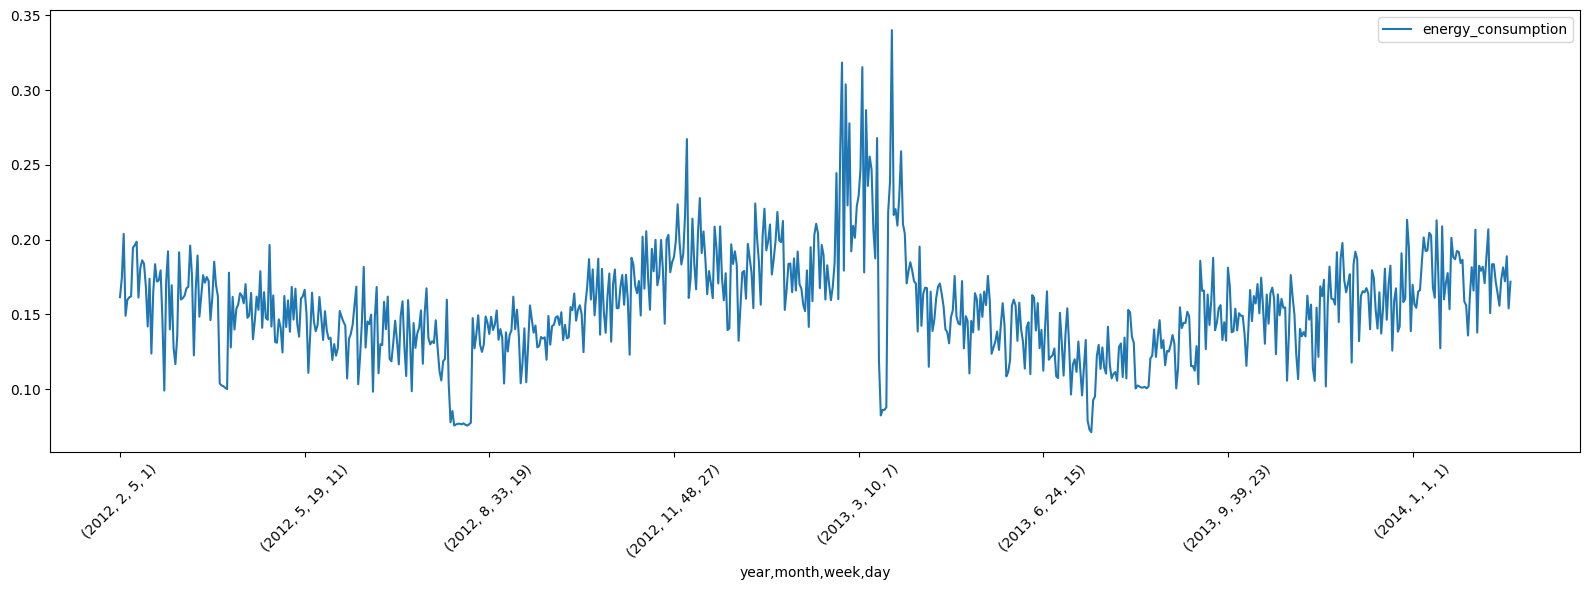

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
daily_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### In this graph (serie plot) there is difference in mean and it seems like there is seasonality so i think this is not stationary

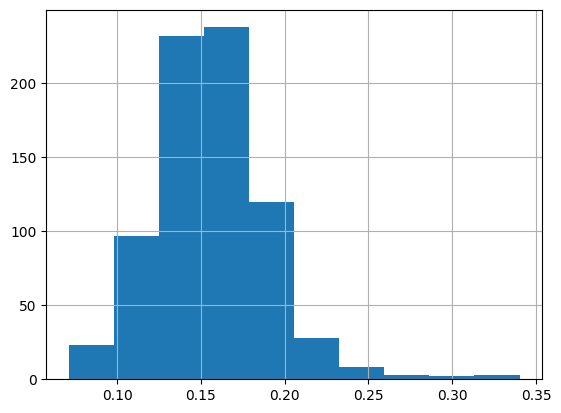

In [87]:
pd.Series(daily_df["energy_consumption"]).hist();

### In the histogram it seems normal distribution so the data have noo trend

In [90]:
daily_df_chunks = ts_df.groupby(["year","month","week","day"])[['energy_consumption']].agg(['mean', 'var']).reset_index()

# Flatten MultiIndex columns
daily_df_chunks.columns = ['_'.join(col).strip('_') for col in daily_df_chunks.columns.values]

# Display
print("hour | Mean       | Variance")
print("-" * 32)
for _, row in daily_df_chunks.iterrows():
    print(f"{int(row['day']):4} | {row['energy_consumption_mean']:.6f} | {row['energy_consumption_var']:.6f}")


hour | Mean       | Variance
--------------------------------
   1 | 0.161500 | 0.006792
   2 | 0.174458 | 0.019289
   3 | 0.203833 | 0.014053
   4 | 0.149083 | 0.003070
   5 | 0.159729 | 0.002442
   6 | 0.161396 | 0.010208
   7 | 0.161979 | 0.008389
   8 | 0.194521 | 0.009644
   9 | 0.196313 | 0.011900
  10 | 0.198562 | 0.013353
  11 | 0.161250 | 0.001630
  12 | 0.181000 | 0.014320
  13 | 0.186146 | 0.010453
  14 | 0.183854 | 0.013870
  15 | 0.168750 | 0.010945
  16 | 0.141896 | 0.008029
  17 | 0.173833 | 0.008008
  18 | 0.123750 | 0.001492
  19 | 0.164917 | 0.005257
  20 | 0.183562 | 0.013461
  21 | 0.171917 | 0.014699
  22 | 0.172729 | 0.010220
  23 | 0.179375 | 0.017221
  24 | 0.145458 | 0.006155
  25 | 0.098958 | 0.001417
  26 | 0.171979 | 0.015200
  27 | 0.192167 | 0.017799
  28 | 0.139937 | 0.001971
  29 | 0.169500 | 0.003834
   1 | 0.127979 | 0.010321
   2 | 0.116667 | 0.003236
   3 | 0.135521 | 0.004341
   4 | 0.191521 | 0.015156
   5 | 0.159917 | 0.013723
   6 | 0.160833 | 0.

### There is difference between means and also between variances so the data is not stationary

In [92]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(daily_df)
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is non stationary")

The adf is :-2.79998042546238,
 The pvalue is :0.05827656420650978,
 The critical_values is :{'1%': np.float64(-3.439290485895927), '5%': np.float64(-2.8654856985173414), '10%': np.float64(-2.568871126669587)}
The pvalue is here > .05 so the data is non stationary


In [93]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(daily_df)

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here < .05 so the data is non stationary")

The kpss is :0.3020051185137052,
 The pvalue is :0.1,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here < .05 so the data is non stationary


<ipython-input-93-c0c854503df4>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(daily_df)


### the two models said that the data is non stationary by day

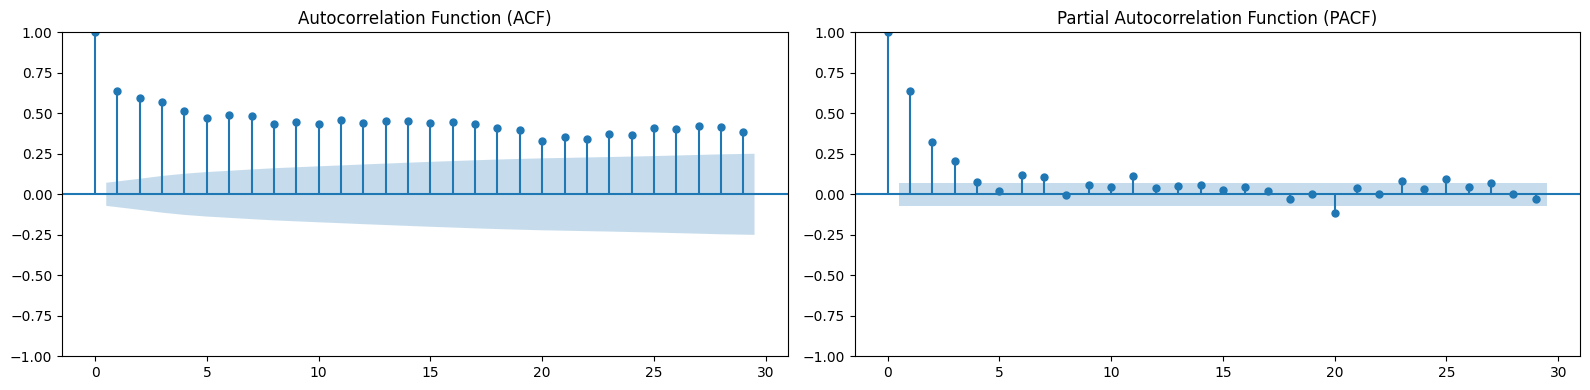

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(daily_df, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(daily_df, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [175]:
train = daily_df.to_numpy()[:-50]
test = daily_df.to_numpy()[-50:]
train_time = np.arange(0, len(train))
test_time = np.arange(len(train), len(train) + len(test))

1. Single Exponential Smoothing (SES)

In [107]:
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598 0.16318598
 0.16318598 0.16318598]
MSE:  [0.02834588 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588
 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588
 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588
 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588
 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588
 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588 0.02834588
 0.02834588 0.0283

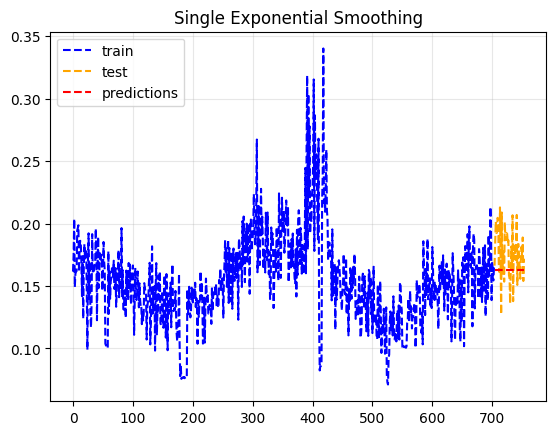

In [108]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

2. Double Exponential Smoothing (DES) - Holt's Linear Trend Method

In [109]:
double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [0.16253385 0.16258438 0.16263491 0.16268543 0.16273596 0.16278649
 0.16283701 0.16288754 0.16293807 0.16298859 0.16303912 0.16308964
 0.16314017 0.1631907  0.16324122 0.16329175 0.16334228 0.1633928
 0.16344333 0.16349386 0.16354438 0.16359491 0.16364544 0.16369596
 0.16374649 0.16379701 0.16384754 0.16389807 0.16394859 0.16399912
 0.16404965 0.16410017 0.1641507  0.16420123 0.16425175 0.16430228
 0.16435281 0.16440333 0.16445386 0.16450438 0.16455491 0.16460544
 0.16465596 0.16470649 0.16475702 0.16480754 0.16485807 0.1649086
 0.16495912 0.16500965]
MSE:  [0.02927482 0.02920132 0.02912809 0.0290551  0.02898238 0.0289099
 0.02883769 0.02876573 0.02869402 0.02862257 0.02855137 0.02848043
 0.02840975 0.02833932 0.02826915 0.02819923 0.02812956 0.02806015
 0.027991   0.0279221  0.02785346 0.02778507 0.02771694 0.02764907
 0.02758144 0.02751408 0.02744697 0.02738011 0.02731351 0.02724717
 0.02718108 0.02711524 0.02704966 0.02698434 0.02691927 0.02685446
 0.0267899  0.0267256

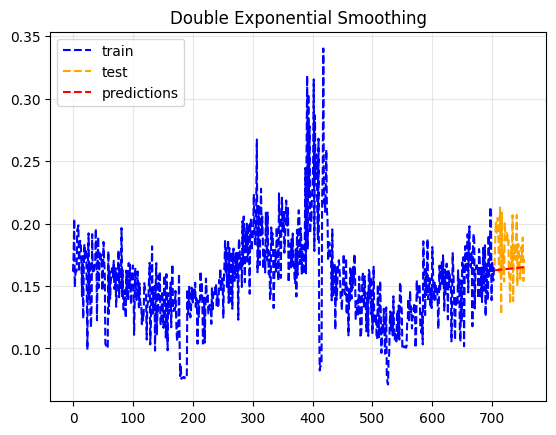

In [110]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

3. Triple Exponential Smoothing (TES) - Holt-Winters' Seasonal Method

In [178]:
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=5).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [0.16314168 0.16070756 0.16388028 0.16276761 0.16373304 0.16306451
 0.16063038 0.16380311 0.16269043 0.16365587 0.16298733 0.16055321
 0.16372594 0.16261326 0.1635787  0.16291016 0.16047604 0.16364876
 0.16253609 0.16350153 0.16283299 0.16039887 0.16357159 0.16245892
 0.16342436 0.16275582 0.1603217  0.16349442 0.16238175 0.16334718
 0.16267865 0.16024452 0.16341725 0.16230457 0.16327001 0.16260147
 0.16016735 0.16334008 0.1622274  0.16319284 0.1625243  0.16009018
 0.1632629  0.16215023 0.16311567 0.16244713 0.16001301 0.16318573
 0.16207306 0.1630385 ]
MSE:  [0.02840764 0.03210263 0.02740362 0.02893695 0.02759941 0.0285157
 0.03222947 0.02750597 0.02904789 0.0277029  0.02862434 0.0323569
 0.02760892 0.02915943 0.02780699 0.02873359 0.03248493 0.02771246
 0.02927156 0.02791167 0.02884343 0.03261356 0.0278166  0.02938428
 0.02801694 0.02895386 0.03274277 0.02792134 0.02949761 0.02812281
 0.02906489 0.03287259 0.02802667 0.02961152 0.02822928 0.02917652
 0.033003   0.028132

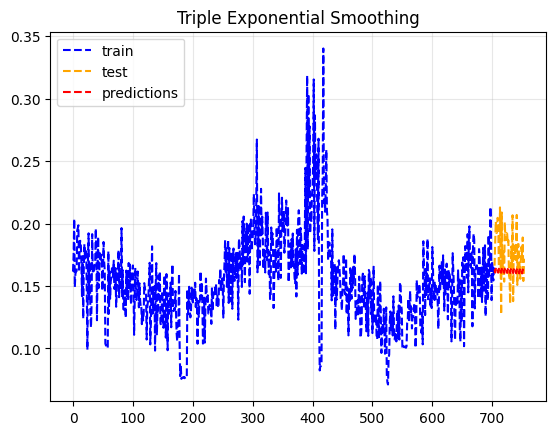

In [179]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

### 1. First analyze the stationarity for precision weekly

In [114]:
weekly_df = ts_df.groupby(["year","month","week"])[['energy_consumption']].mean()
weekly_df

energy_consumption
year month week                    
2012 2     5               0.169721
           6               0.179289
           7               0.163307
           8               0.160568
           9               0.167201
...                             ...
2014 1     5               0.164267
     2     5               0.171635
           6               0.174949
           7               0.178545
           8               0.171021

[129 rows x 1 columns]

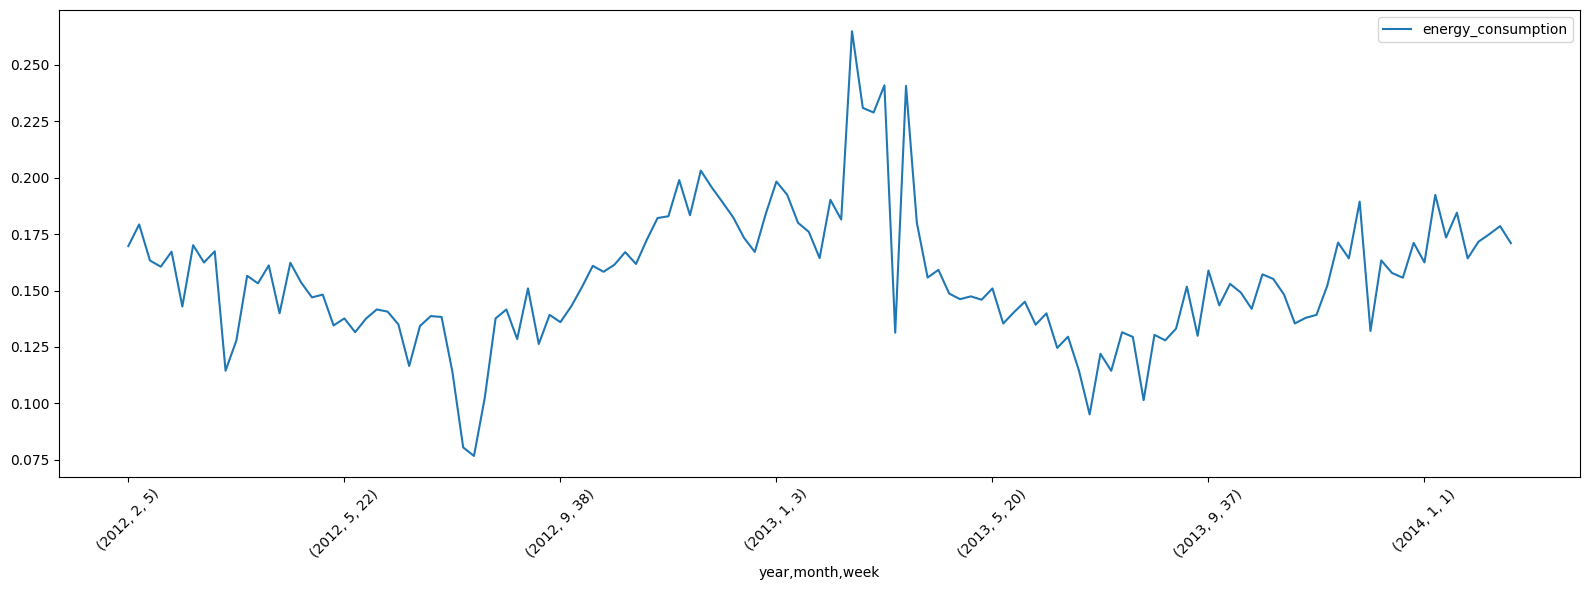

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
weekly_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### It seems like there is seasonality in the data (weekly) so it is non stationary


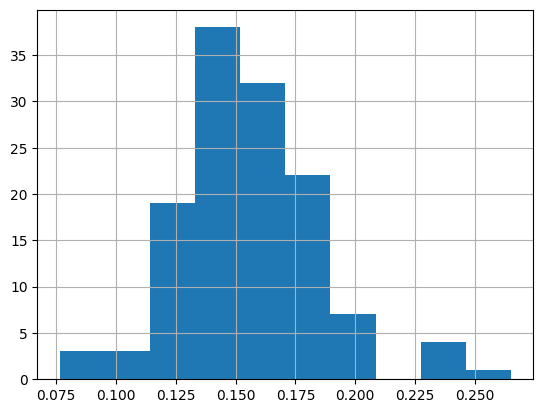

In [117]:
pd.Series(weekly_df["energy_consumption"]).hist();

### In the histogram iit seems normal distribution so the data has noo trend

In [119]:
weekly_df_chunks = ts_df.groupby(["year","month","week"])[['energy_consumption']].agg(['mean', 'var']).reset_index()
# Flatten MultiIndex columns
weekly_df_chunks.columns = ['_'.join(col).strip('_') for col in weekly_df_chunks.columns.values]

# Display
print("hour | Mean       | Variance")
print("-" * 32)
for _, row in weekly_df_chunks.iterrows():
    print(f"{int(row['week']):4} | {row['energy_consumption_mean']:.6f} | {row['energy_consumption_var']:.6f}")


hour | Mean       | Variance
--------------------------------
   5 | 0.169721 | 0.009334
   6 | 0.179289 | 0.010007
   7 | 0.163307 | 0.008590
   8 | 0.160568 | 0.011757
   9 | 0.167201 | 0.008218
   9 | 0.142922 | 0.008970
  10 | 0.170104 | 0.010531
  11 | 0.162432 | 0.010249
  12 | 0.167387 | 0.011835
  13 | 0.114465 | 0.005344
  13 | 0.127854 | 0.010143
  14 | 0.156527 | 0.011574
  15 | 0.153179 | 0.011477
  16 | 0.161140 | 0.011207
  17 | 0.139902 | 0.007564
  18 | 0.162312 | 0.011848
  18 | 0.153528 | 0.011997
  19 | 0.146973 | 0.006385
  20 | 0.148179 | 0.009494
  21 | 0.134512 | 0.009147
  22 | 0.137646 | 0.006595
  22 | 0.131549 | 0.007299
  23 | 0.137539 | 0.008824
  24 | 0.141619 | 0.007734
  25 | 0.140658 | 0.009580
  26 | 0.135000 | 0.005382
  26 | 0.116542 | 0.003033
  27 | 0.134265 | 0.005301
  28 | 0.138676 | 0.007871
  29 | 0.138280 | 0.007826
  30 | 0.114045 | 0.002873
  31 | 0.080469 | 0.001230
  31 | 0.076687 | 0.000285
  32 | 0.102485 | 0.005361
  33 | 0.137649 | 0.

### There is difference between means and also between variances so the data is non stationary

In [121]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(weekly_df)
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is non stationary")

The adf is :-1.8917756220279283,
 The pvalue is :0.33593995419762246,
 The critical_values is :{'1%': np.float64(-3.484219653271961), '5%': np.float64(-2.885145235641637), '10%': np.float64(-2.579359138917794)}
The pvalue is here > .05 so the data is non stationary


In [122]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(weekly_df)

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here < .05 so the data is non stationary")

The kpss is :0.15568224569281364,
 The pvalue is :0.1,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here < .05 so the data is non stationary


<ipython-input-122-8022075b6795>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(weekly_df)


### There is conflict between two tests  
- KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

In [125]:
train = weekly_df.to_numpy()[:-5]
test = weekly_df.to_numpy()[-5:]
train_time = np.arange(0, len(train))
test_time = np.arange(len(train), len(train) + len(test))

1. Single Exponential Smoothing (SES)

In [126]:
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [0.17954124 0.17954124 0.17954124 0.17954124 0.17954124]
MSE:  [0.00039049 0.00039049 0.00039049 0.00039049 0.00039049]


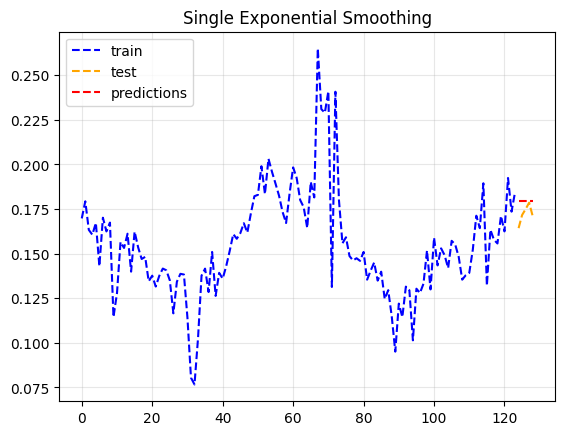

In [127]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

2. Double Exponential Smoothing (DES) - Holt's Linear Trend Method

In [128]:
double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [0.18417595 0.18631176 0.18844756 0.19058336 0.19271917]
MSE:  [0.00084354 0.00112462 0.00145132 0.00182364 0.00224157]


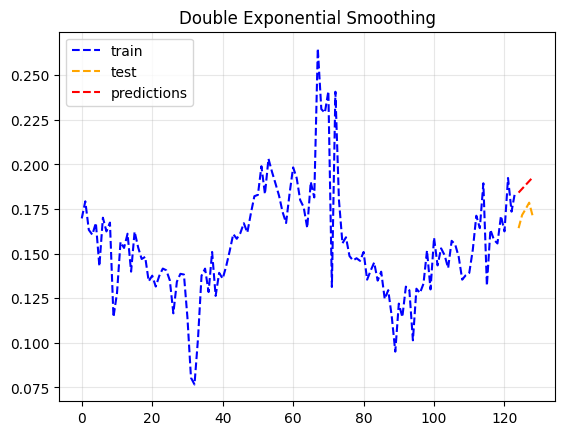

In [129]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

3. Triple Exponential Smoothing (TES) - Holt-Winters' Seasonal Method

In [130]:
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [0.19331028 0.18938158 0.18546108 0.18536652 0.18196976]
MSE:  [0.0023653  0.00160853 0.00100721 0.0009946  0.00060109]


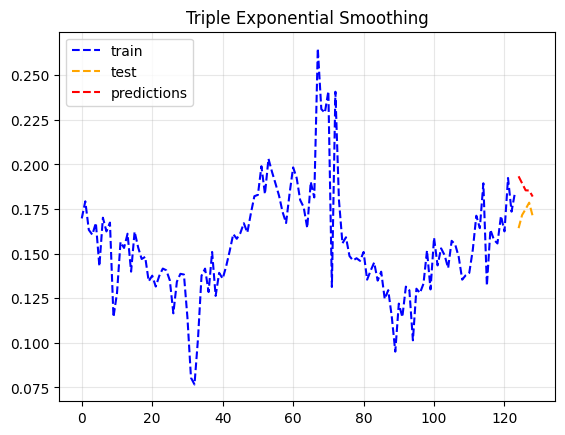

In [131]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

### analyze the stationarity for precision monthly

In [133]:
monthly_df = ts_df.groupby(["year","month"])[['energy_consumption']].mean()
monthly_df

energy_consumption
year month                    
2012 2                0.168012
     3                0.153482
     4                0.152180
     5                0.144497
     6                0.138112
     7                0.127559
     8                0.119288
     9                0.137106
     10               0.158927
     11               0.180156
     12               0.186305
2013 1                0.185298
     2                0.190714
     3                0.212451
     4                0.159931
     5                0.144031
     6                0.133068
     7                0.113479
     8                0.123690
     9                0.146567
     10               0.148923
     11               0.154574
     12               0.162784
2014 1                0.176979
     2                0.174560

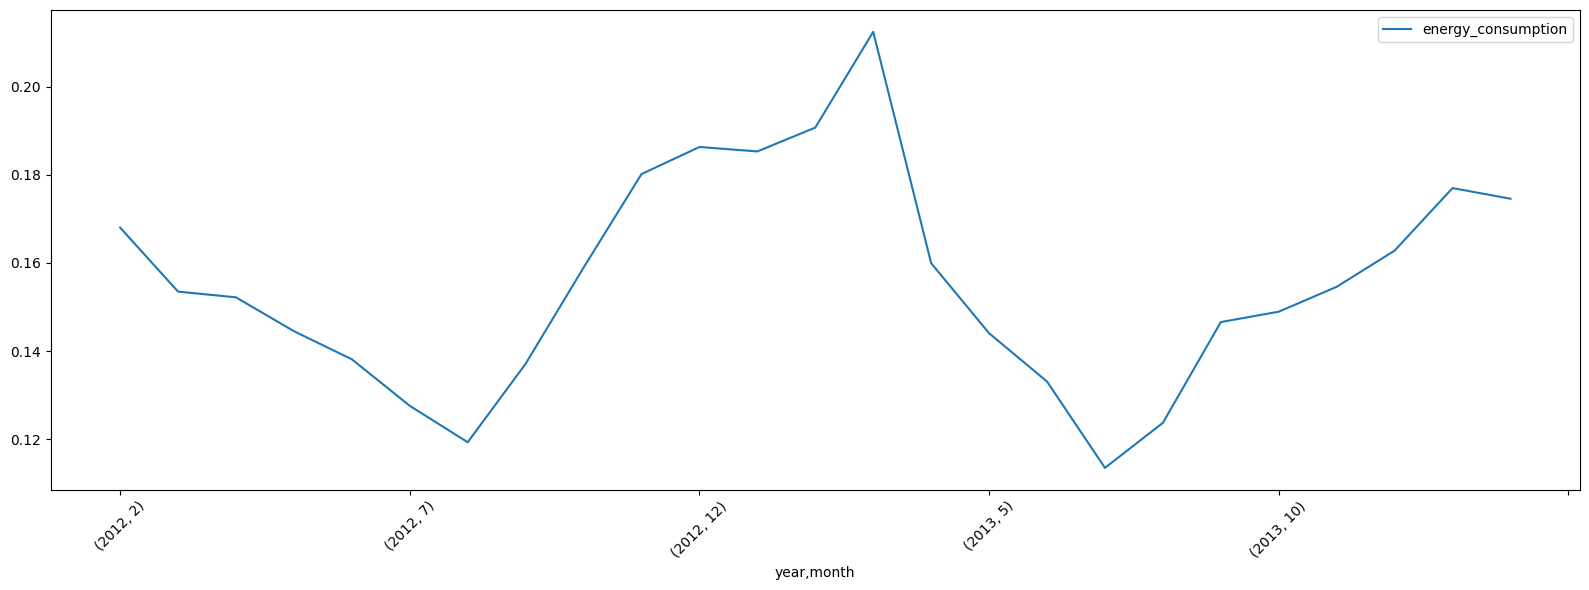

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
monthly_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### In this graph (serie plot) there is seasonality so it seems not startionary be week

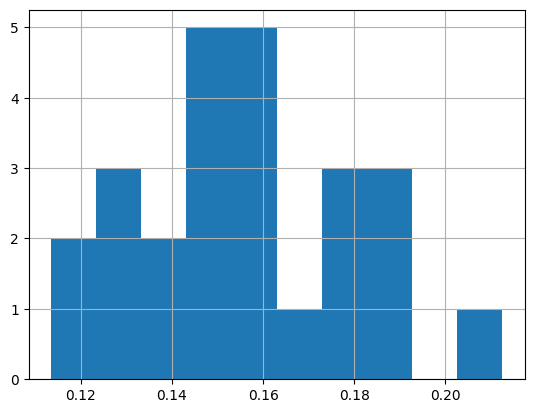

In [135]:
pd.Series(monthly_df["energy_consumption"]).hist();

### I think this is uniform distribution so it indicates that the data have a trend

In [137]:
monthly_df_chunks = ts_df.groupby(["year","month"])[['energy_consumption']].agg(['mean', 'var']).reset_index()
# Flatten MultiIndex columns
monthly_df_chunks.columns = ['_'.join(col).strip('_') for col in monthly_df_chunks.columns.values]

# Display
print("hour | Mean       | Variance")
print("-" * 32)
for _, row in monthly_df_chunks.iterrows():
    print(f"{int(row['month']):4} | {row['energy_consumption_mean']:.6f} | {row['energy_consumption_var']:.6f}")


hour | Mean       | Variance
--------------------------------
   2 | 0.168012 | 0.009809
   3 | 0.153482 | 0.009965
   4 | 0.152180 | 0.010536
   5 | 0.144497 | 0.008849
   6 | 0.138112 | 0.007895
   7 | 0.127559 | 0.005805
   8 | 0.119288 | 0.006367
   9 | 0.137106 | 0.006245
  10 | 0.158927 | 0.008354
  11 | 0.180156 | 0.012965
  12 | 0.186305 | 0.011198
   1 | 0.185298 | 0.011249
   2 | 0.190714 | 0.029133
   3 | 0.212451 | 0.073984
   4 | 0.159931 | 0.014955
   5 | 0.144031 | 0.008644
   6 | 0.133068 | 0.008631
   7 | 0.113479 | 0.004350
   8 | 0.123690 | 0.006182
   9 | 0.146567 | 0.009574
  10 | 0.148923 | 0.010011
  11 | 0.154574 | 0.009554
  12 | 0.162784 | 0.009849
   1 | 0.176979 | 0.010344
   2 | 0.174560 | 0.008680


### There is no difference between means and also between variances so the data is not stationary

In [142]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(monthly_df)
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is stationary")

The adf is :-3.2098135632709877,
 The pvalue is :0.01942361282075365,
 The critical_values is :{'1%': np.float64(-3.7883858816542486), '5%': np.float64(-3.013097747543462), '10%': np.float64(-2.6463967573696143)}
The pvalue is here > .05 so the data is stationary


In [141]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(monthly_df)

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is stationary")

The kpss is :0.07413690348911399,
 The pvalue is :0.1,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here > .05 so the data is stationary


<ipython-input-141-8253afc1ab9c>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(monthly_df)


### The two tests said that the data is stationary but there are not sure

In [164]:
train = monthly_df.to_numpy()[:-2]
test = monthly_df.to_numpy()[-2:]
train_time = np.arange(0, len(train))
test_time = np.arange(len(train), len(train) + len(test))

1. Single Exponential Smoothing (SES)

In [165]:
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [0.16278427 0.16278427]
MSE:  [0.00034016 0.00034016]


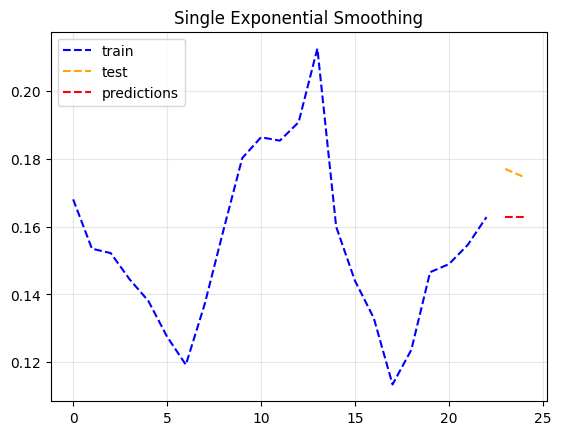

In [173]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

2. Double Exponential Smoothing (DES) - Holt's Linear Trend Method

In [167]:
double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [0.16736537 0.17194648]
MSE:  [1.44184499e-04 3.21573549e-05]


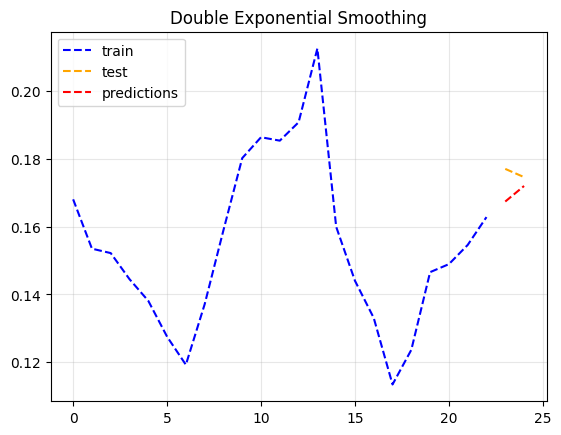

In [168]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

3. Triple Exponential Smoothing (TES) - Holt-Winters' Seasonal Method

In [169]:
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=2).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [0.1646095  0.16231712]
MSE:  [0.00025202 0.00036486]


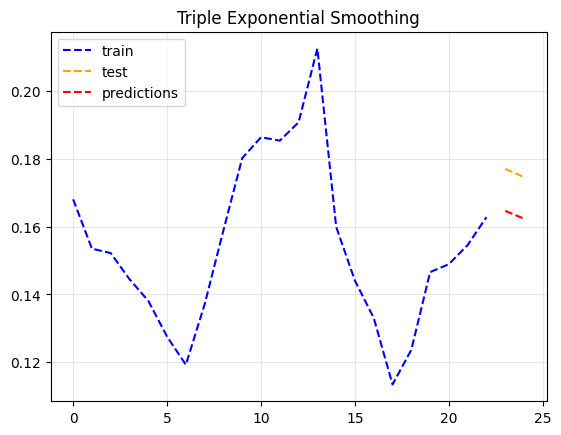

In [170]:
plt.plot(train_time, train, 'b--', label="train")
plt.plot(test_time, test, color='orange', linestyle="--", label="test")
plt.plot(test_time, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);